In [232]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pickle
from collections import Counter
%matplotlib nbagg

In [11]:
df = pd.read_csv('upwork_df.csv', index_col=0)
df['time'] = df['time'].apply(pd.to_datetime)
df = df.dropna(subset=['title', 'desc']).reset_index(drop=True)

In [50]:
df.head()

,budget,desc,duration,key,level,skills,time,title,type
0,20.0,hello need someone who can help scrape mails f...,NaN,01241f8bc8bbbb99bf,entry,data_scraping microsoft_excel microsoft_office...,2018-01-06 09:07:03,mail scraping,fixed
1,NaN,need develop app ios andriod for blockcian and...,"1 to 3 months, 30+ hrs/week",01eb1de51bfccf3bca,expert,android_app_development blockchain ios_develop...,2018-01-06 08:47:35,cryptocurrency app,hourly
2,80.0,need matlab program which can detect medals ta...,NaN,01a1df3c46e33e463e,entry,NaN,2018-01-06 07:21:31,object recognition using matlab,fixed
3,40.0,hello seasoning and spice company that need re...,NaN,01e3e967e1a881849b,expert,NaN,2018-01-06 06:59:26,restaurant data needed,fixed
4,500.0,looking for experienced developer who has crea...,NaN,014202d8654f9d6de3,intermediate,website_development,2018-01-06 06:36:30,web scraper and analysis algo reddit twitter m...,fixed


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 9 columns):
budget      794 non-null float64
desc        2027 non-null object
duration    1111 non-null object
key         2027 non-null object
level       2027 non-null object
skills      1534 non-null object
time        2027 non-null datetime64[ns]
title       2027 non-null object
type        2027 non-null object
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 142.6+ KB


In [401]:
def get_skills_dict(df):
    skills = {}
    for row in df['skills'].values.tolist():
        if type(row) != float:
            content = row.split()
            for tag in content:
                if tag not in skills.keys():
                    skills[tag] = 0
                skills[tag] += 1
    del skills['r']; del skills['c']
    return skills

In [402]:
skills = get_skills_dict(df)

In [403]:
sorted(skills.items(), key=operator.itemgetter(1), reverse=True)

[('microsoft_excel', 248),
 ('python', 234),
 ('data_mining', 195),
 ('web_scraping', 183),
 ('data_science', 172),
 ('machine_learning', 168),
 ('data_scraping', 166),
 ('data_analytics', 156),
 ('statistics', 120),
 ('data_entry', 116),
 ('internet_research', 79),
 ('excel_vba', 74),
 ('artificial_intelligence', 66),
 ('sql', 62),
 ('quantitative_analysis', 60),
 ('data_visualization', 55),
 ('mathematics', 54),
 ('tableau_software', 52),
 ('c_', 52),
 ('deep_learning', 51),
 ('php', 50),
 ('natural_language_processing', 48),
 ('business_analysis', 48),
 ('javascript', 44),
 ('financial_analysis', 43),
 ('google_analytics', 40),
 ('artificial_neural_networks', 38),
 ('financial_modeling', 36),
 ('analytics', 36),
 ('matlab', 35),
 ('tensorflow', 33),
 ('lead_generation', 33),
 ('deep_neural_networks', 33),
 ('microsoft_power_bi', 30),
 ('java', 30),
 ('api_development', 28),
 ('research', 26),
 ('predictive_analytics', 25),
 ('foreign_exchange_trading', 25),
 ('computer_vision', 25),

### Similarity by "skills":

In [381]:
class TagSimilarity:
    
    def __init__(self, skills, df):
        self.df_new = pd.DataFrame(index=df.index)
        for skill in skills: 
            if skill not in self.df_new.columns:
                self.df_new[skill] = 0
            self.df_new.loc[(df['skills'].notnull() & df['skills'].str.contains(skill)), skill] = 1
        self.sim = np.empty((self.df_new.shape[0], self.df_new.shape[0]))
        self.indexes = self.df_new.index.tolist()
    
    def train(self):
        for i in tqdm.tqdm(self.indexes, desc='training'):
            for j in self.indexes[::-1]:
                mult = self.df_new.loc[i].values * self.df_new.loc[j].values
                self.sim[i, j] = np.sum(mult)
                
    def get(self, row):
        counter, sim_new = 0, np.empty(self.sim.shape[1])
        row = row.split()
        new_id = self.df_new.index[-1]+1
        new_row = pd.DataFrame(np.zeros((1, self.df_new.shape[1])), columns=self.df_new.columns)
        for skill in row:
            if skill in self.df_new.columns:
                new_row[skill] = 1
        for i in tqdm.tqdm(self.indexes, desc='prediction'):
            mult = self.df_new.loc[i].values * new_row
            sim_new[i] = len(mult[mult == 1])
        return np.argmax(sim_new)

In [382]:
sim = TagSimilarity(skills, df)

In [383]:
%%time

sim.train()

training: 100%|██████████| 2027/2027 [16:54<00:00,  2.14it/s]

CPU times: user 16min 47s, sys: 3.84 s, total: 16min 51s
Wall time: 16min 54s


In [384]:
pickle.dump(sim, open('./data/similarity.pickle.dat', 'wb'))

In [385]:
diag = []
for i in range(sim.sim.shape[0]):
    diag.append( np.max(sim.sim[i, i]) )

In [386]:
counts = Counter(diag)

In [388]:
sorted(counts.items(), key=operator.itemgetter(1), reverse=True)

[(0.0, 505),
 (3.0, 281),
 (1.0, 268),
 (2.0, 236),
 (4.0, 208),
 (5.0, 191),
 (6.0, 103),
 (7.0, 70),
 (8.0, 57),
 (9.0, 31),
 (10.0, 22),
 (12.0, 12),
 (11.0, 8),
 (20.0, 8),
 (14.0, 6),
 (16.0, 6),
 (15.0, 4),
 (13.0, 2),
 (19.0, 2),
 (24.0, 2),
 (61.0, 1),
 (29.0, 1),
 (18.0, 1),
 (22.0, 1),
 (21.0, 1)]

<IPython.core.display.Javascript object>


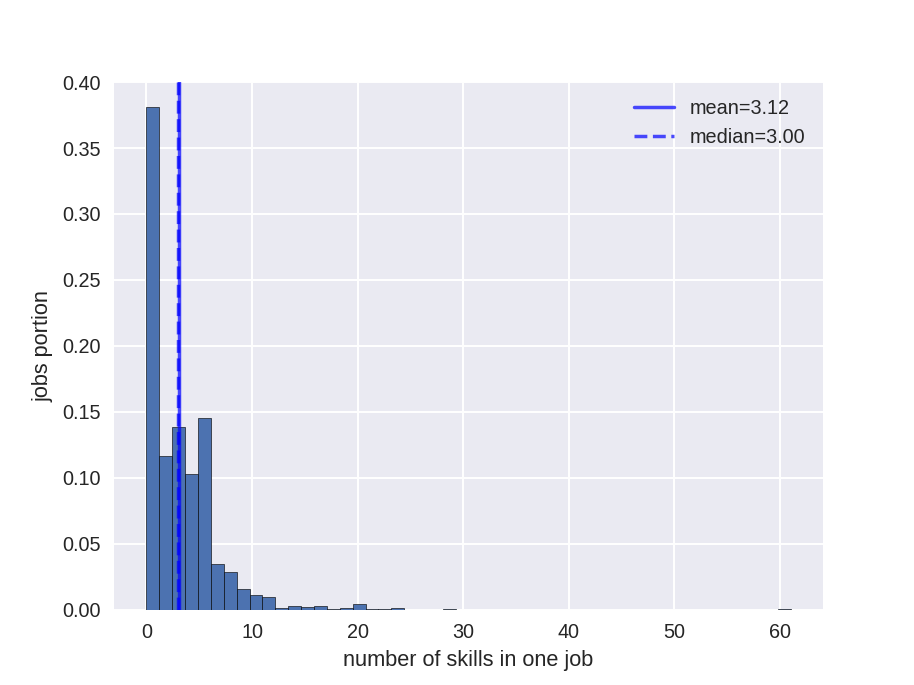

In [389]:
weights = np.ones_like(diag)/float(len(diag))
plt.hist(diag, weights=weights, bins=50, edgecolor='black')
plt.axvline(np.mean(diag), color='b', label='mean=%.2f' % np.mean(diag), alpha=0.7)
plt.axvline(np.median(diag), color='b', linestyle='--', label='median=%.2f' % np.median(diag), alpha=0.7)
plt.xlabel('number of skills in one job')
plt.ylabel('jobs portion')
plt.legend(loc='best')
plt.show()

#### Test:

In [390]:
closest_id = sim.get(df.iloc[0]['skills'])

prediction: 100%|██████████| 2027/2027 [00:04<00:00, 481.65it/s]


In [398]:
print('Intersection:', sim.df_new.iloc[closest_id].sum(), 'tags')

Intersection: 4 tags


In [400]:
df.loc[0]['skills'], df.loc[closest_id]['skills']

('data_scraping microsoft_excel microsoft_office web_scraping',
 'data_scraping microsoft_excel microsoft_office web_scraping')

### Descriptions to LSI vectors:

In [16]:
import operator
from langdetect import *
import nltk
from gensim.utils import deaccent

In [56]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/gas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [404]:
def iso_639_1(lang):
    d = {
        'da':'danish',
        'nl':'dutch',
        'en':'english',
        'fi':'finnish',
        'fr':'french',
        'de':'german',
        'hu':'hungarian',
        'it':'italian',
        'kk':'kazakh',
        'no':'norwegian',
        'pt':'portuguese',
        'ru':'russian',
        'es':'spanish',
        'sv':'swedish',
        'tr':'turkish'
    }
    return d[lang]

def getTokens(text, garbage=['hello', 'hi', 'need', 'help', 'com', 'http']):
    tokenizer = nltk.RegexpTokenizer('\w+')        
    lmtzr = nltk.stem.wordnet.WordNetLemmatizer()
    try:
        lang = detect(text)
        garbage += nltk.corpus.stopwords.words(iso_639_1(lang))
    except:
        pass
    garbage = set(garbage)
    text = tokenizer.tokenize(text)
    text = [lmtzr.lemmatize(deaccent(word.lower())) for word in text]
    text = [word for word in text if len(word) > 2 and word not in garbage]
    return text

In [ ]:
#stream funcs

def corpus_gen(fname, range_=None):
    i = 0
    with open(fname, 'r') as f:
        for line in f:
            if range_:
                if i < range_:
                    i += 1
                    yield line.split()
            else:
                yield line.split()

class doc2bow_(object):
    def __init__(self, fname, range_=None):
        self.fname = fname
        self.range_ = range_
        self.vals = set(dictionary.values())
    def __iter__(self):
        i = 0
        with open(self.fname, 'r') as f:
            for line in f:
                if self.range_:
                    if i < self.range_:
                        i += 1
                        yield dictionary.doc2bow(trigram[bigram[[word for word in line.split() if word in self.vals]]])
                else:
                    yield dictionary.doc2bow(trigram[bigram[[word for word in line.split() if word in self.vals]]])
            
#add new doc to existed models & refresh at all steps

def evaluate_models(data, fname=None, save=False, additions=False):
    
    #update *.txt file
    
    text = html_to_txt(data, additions=additions, fname=fname, save=save)
        
    #update dict & create tfidf representation of current doc
                        
    bigram_phrases.add_vocab(text)
    trigram_phrases.add_vocab(bigram_phrases[text])
    text = trigram_phrases[bigram_phrases[text]]
    dictionary.add_documents([text], prune_at=None)
    dictionary.filter_extremes(no_below=2, no_above=0.8, keep_n=None)
    dictionary.compactify()
    vals = set(dictionary.values())
    text = [word for word in text if word in vals]
    add = dictionary.doc2bow(text)
    tfidf = gensim.models.TfidfModel(dictionary=dictionary)

    #update LSI model

    lsimodel.add_documents(tfidf[[add]], decay=0.5)

    #update distances

    dist.add_documents(lsimodel[tfidf[[add]]])
    return tfidf

def evaluate_dist(url, additions=False, fname=None, save=False):
    text = html_to_txt(url, additions=additions, fname=fname, save=save)
    text = trigram[bigram[text]]
    vals = set(dictionary.values())
    text = [word for word in text if word in vals]
    add = dictionary.doc2bow(text)
    dist.add_documents(lsimodel[tfidf[[add]]])

In [ ]:
#save corpuses

def corpuses(corp=None, path=None, mode='save'):

    if mode not in ('save', 'load'):
        raise ValueError("`mode` must be either 'save' or 'load'.")
        
    if mode == 'save':
        gensim.corpora.MmCorpus.save_corpus(path + '/corpus_tfidf.mm', corp)
        #pickle.dump(corp, open(path + r'/corpus_tfidf.pickle.dat', "wb"))
    elif mode == 'load':
        corpus_tfidf = gensim.corpora.MmCorpus.load(path + '/corpus_tfidf.mm', mmap='r')
        #corpus_tfidf = pickle.load(open(path + r'/corpus_tfidf.pickle.dat', "rb"))
        return corpus_tfidf
    
#load existed data

bigram = gensim.models.Phrases.load(path + '/bigram', mmap='r')
trigram = gensim.models.Phrases.load(path + '/trigram', mmap='r')
#bigram_phrases = gensim.models.phrases.Phraser.load(path + '/bigram_phrases', mmap='r')
#trigram_phrases = gensim.models.phrases.Phraser.load(path + '/trigram_phrases', mmap='r')
dictionary = gensim.corpora.Dictionary.load(path + '/dict', mmap='r')
tfidf = gensim.models.TfidfModel.load(path + '/tf_idf_model', mmap='r')
#corpus_tfidf = corpuses(path=path, mode='load')
lsimodel = gensim.models.lsimodel.LsiModel.load(path + '/lsimodel')
#dist = gensim.similarities.docsim.Similarity.load(path + '/similarity')

#save all

bigram.save(path + '/bigram')
trigram.save(path + '/trigram')
#bigram_phrases.save(path + '/bigram_phrases')
#trigram_phrases.save(path + '/trigram_phrases')
dictionary.save(path + '/dict')
tfidf.save(path + '/tf_idf_model')
dist.save(path + '/similarity')
lsimodel.save(path + '/lsimodel')

In [ ]:
#if num_best not None -> distances will be auto-sorted

dist.num_best = 10
dist_sort_ = dist[lsimodel[tfidf[dictionary.doc2bow(trigram[bigram[doc]])]]]
#dist_sort_ = [i for i in dist_sort if i[1] >= 0.4]

%%time

#key words for query

topic_ = lsimodel[tfidf[dictionary.doc2bow(trigram[bigram[doc]])]]
doc_scores = sorted([(topic, abs(score)) for topic, score in topic_],
                    key=operator.itemgetter(1), reverse=True)
for score in doc_scores[0:6]: 
    for word in lsimodel.show_topic(score[0], topn=4):
        print(word[0].replace('_', ' '))

In [ ]:
bigram_phrases = gensim.models.phrases.Phrases(corpus_gen(path + name, range_=range_))
bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram_phrases = gensim.models.phrases.Phrases(bigram[corpus_gen(path + name, range_=range_)])
trigram = gensim.models.phrases.Phraser(trigram_phrases)

dictionary = gensim.corpora.Dictionary(trigram[bigram[corpus_gen(path + name, range_=range_)]])
dictionary.filter_extremes(no_below=2, no_above=0.8, keep_n=None)
dictionary.compactify()

corpus = doc2bow_(path + name, range_=range_)
tfidf = gensim.models.TfidfModel(dictionary=dictionary)
corpus_tfidf = tfidf[corpus]

lsimodel = gensim.models.lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=50)

dist = gensim.similarities.docsim.Similarity(path + '/',
                                             lsimodel[corpus_tfidf],
                                             (lsimodel.projection.s).shape[0], num_best=None, 
                                             chunksize=256, shardsize=32768, norm='l1')


In [65]:
getTokens(df['desc'].iloc[2])

['matlab',
 'program',
 'detect',
 'medal',
 'tab',
 'ribbon',
 'uniform',
 'soldier',
 'input',
 'image',
 'soldier',
 'run',
 'matlab',
 'program',
 'get',
 'result',
 'tell',
 'decoration',
 'tab',
 'medal',
 'rank',
 'soldier',
 'wearing',
 'uniform']